# 5. Computer Vision classification challenge

## Exploratory analysis and baseline model training and evaluation

Use a sample of images from the swimming-pool dataset to develop a model that classifies whether an image contains a swimming pool or not. Use the provided labels to validate your model.

## Experiment

The `CAFormer` model shown significant improvement over the `convnext` models on most metrics. We will therefore proceed with `caformer_s36.sail_in22k_ft_in1k_384` as the current model of choice.

The aim of this experiment is to test whether validation accuracy can be further improved by training for more epochs, and adding basic data augmentations to prevent overfitting and to expose the model to more diverse training data.

We will evaluate the following metrics on the validation set:
- [Balanced accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html)
- [Average Precision (AP)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html)
- [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
- [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
- [Area Under the Receiver Operating Characteristic Curve (ROC AUC)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)

## Setup

The cell below is specifically for running the notebook in a Kaggle or Paperspace Gradient Notebooks environment.
- If running the notebook in Kaggle, make sure the `stefan87/cct-ds-code-challenge` dataset is attached to the Kaggle notebook.
- If running the notebook in Paperspace Gradient, the images are assumed to be in `/notebooks/ds_code_challenge_data/images/swimming-pool/`.

After all packages have been installed, the kernel will automatically be restarted. When that process is complete, the notebook can be run from the top (including the first cell).

For all other environments, it is assumed that all dependencies have already been installed. The cell below must still be run.

In [1]:
import os

is_kaggle = True if os.environ.get('KAGGLE_URL_BASE', '') else False
is_paperspace = True if os.environ.get('PAPERSPACE_NOTEBOOK_ID', '') else False

if is_kaggle or is_paperspace:
    env = "Kaggle" if is_kaggle else "Paperspace"
    home_dir = "/kaggle/working" if is_kaggle else "/notebooks"
    print(f"This notebook is running on {env}.")
    if not os.path.exists(f"{home_dir}/ds_code_challenge"):
        print("Installing additional packages...")
        os.system("git clone https://github.com/stefan027/ds_code_challenge.git")
        if is_kaggle:
            os.system("curl -LsSf https://astral.sh/uv/install.sh | sh")
            os.system("cd ds_code_challenge && uv pip install -r requirements.txt")
            # restart the kernel after installing packages
            os._exit(00)
        else:
            os.system("pip uninstall wandb pyarrow -y")
            os.system("cd ds_code_challenge && pip install -r requirements.txt")
            # restart the kernel after installing packages
            os._exit(00)
    os.chdir(f"{home_dir}/ds_code_challenge")

This notebook is running on Paperspace.


In [ ]:
import sys

# Add the repo root to the Python path
sys.path.append("../")

import os
from pathlib import Path
from importlib.metadata import version
from typing import Union
import random

from fastai.vision.all import (
    set_seed, DataLoader, DataLoaders, Learner,
    BCEWithLogitsLossFlat, Adam, CSVLogger
)
from PIL import Image
import numpy as np
import pandas as pd
from IPython.display import display
import torch
import albumentations as A

from src.data import TiffImageDataset
from src.modeling import (
    create_timm_model, freeze_except_head, unfreeze_all
)
from src.metrics import (
    balanced_accuracy, ap_score, precision, recall, roc_auc
)

In [3]:
pckgs = ["torch", "torchvision", "fastai", "timm"]
for pckg in pckgs:
    print(f"{pckg}=={version(pckg)}")

torch==2.8.0
torchvision==0.23.0
fastai==2.8.4
timm==1.0.20


In [4]:
if is_kaggle:
    IMAGE_DIR = Path("/kaggle/input/cct-ds-code-challenge/images/swimming-pool")
elif is_paperspace:
    IMAGE_DIR = Path("/notebooks/ds_code_challenge_data/images/swimming-pool")
else:
    IMAGE_DIR = Path("../data/images/swimming-pool")
CLASSES = ["no", "yes"]
POSITIVE_CLASS = "yes"
VALIDATION_PCT = 0.2

Set the random seed for reproducibility. The `set_seed` function sets the seed for `numpy`, `random`, and `torch`.

In [5]:
set_seed(42, reproducible=True)

## Load data

In [6]:
image_paths = [IMAGE_DIR/f"{category}/{f}" for category in CLASSES for f in os.listdir(IMAGE_DIR/category)]

Check the file extensions and get value counts:

In [7]:
# Check the file extensions and get value counts
pd.Series([fp.suffix for fp in image_paths]).value_counts()

.tif    7043
           2
Name: count, dtype: int64

Remove non-TIF files:

In [8]:
# Remove non-TIF files
image_paths = [fp for fp in image_paths if fp.suffix.lower() == ".tif"]
print(f"Number of image files: {len(image_paths)}")

Number of image files: 7043


Create a function to derive the binary label from an image file path:

In [9]:
def get_label(fp: Union[str, Path], positive_class: str) -> str:
    """Extracts the label from the file path."""
    label = Path(fp).parts[-2]
    return int(label == positive_class)

In [10]:
# example usage
get_label(image_paths[0], POSITIVE_CLASS)

0

Get the labels for each image file and look at the class distribution:

In [11]:
labels = [get_label(fp, POSITIVE_CLASS) for fp in image_paths]
# Look at class distribution
pd.Series(labels).value_counts()

1    4643
0    2400
Name: count, dtype: int64

Create training- and validation splits. While there is class imbalance, given that we only have two classes and we have a relatively large sample of images, doing a simple random split should result in similarly balanced training and validation splits.

In [12]:
valid_idx = sorted(random.sample(range(len(image_paths)),
                                 k=int(len(image_paths)*VALIDATION_PCT)))
train_idx = sorted(list(set(range(len(image_paths))) - set(valid_idx)))
train_fps, train_labels = [image_paths[i] for i in train_idx], [labels[i] for i in train_idx]
valid_fps, valid_labels = [image_paths[i] for i in valid_idx], [labels[i] for i in valid_idx]
print(f"Training set size:   {len(train_fps)}")
print(f"Validation set size: {len(valid_fps)}")
print("Percentage positive class:")
print(f"  - Training:   {sum(train_labels) / len(train_labels) * 100:.1f}%")
print(f"  - Validation: {sum(valid_labels) / len(valid_labels) * 100:.1f}%")

Training set size:   5635
Validation set size: 1408
Percentage positive class:
  - Training:   66.1%
  - Validation: 65.4%


Look at some sample images:

Path: /notebooks/ds_code_challenge_data/images/swimming-pool/no/W24C_23_73.tif, Label: 0


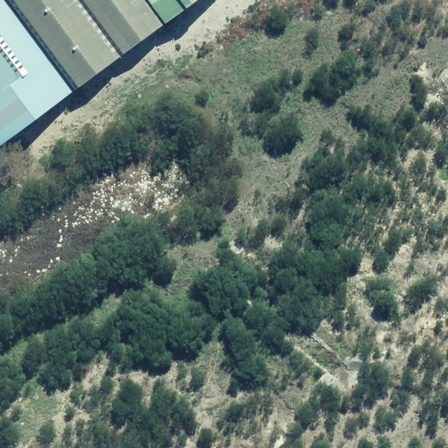

Path: /notebooks/ds_code_challenge_data/images/swimming-pool/yes/W35B_3_40.tif, Label: 1


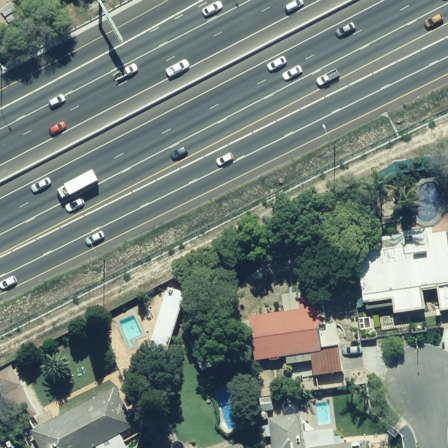

In [13]:
# Look at some sample images
sz = (448, 448)
for _ in range(2):
    i = random.randint(0, len(image_paths)-1)
    print(f"Path: {image_paths[i]}, Label: {labels[i]}")
    display(Image.open(image_paths[i]).resize(sz))

## Create `Dataset`s and `DataLoaders`

In [14]:
train_transform = A.Compose([
    A.Resize(384, 384),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
])
val_transform = A.Compose([
    A.Resize(384, 384),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
])
ds_trn = TiffImageDataset(paths=train_fps, labels=train_labels, transform=train_transform, use_albumentations=True)
ds_val = TiffImageDataset(paths=valid_fps, labels=valid_labels, transform=val_transform, use_albumentations=True)

In [15]:
dls_trn = DataLoader(ds_trn, batch_size=16, shuffle=True)
dls_val = DataLoader(ds_val, batch_size=16, shuffle=False)
dls = DataLoaders(dls_trn, dls_val)

In [16]:
x, y = dls.one_batch()
print(f"Image tensor shape: {x.shape}")
print(f"Label tensor shape: {y.shape}")

Image tensor shape: torch.Size([16, 3, 384, 384])
Label tensor shape: torch.Size([16])


## Setup model

In [17]:
model, cfg = create_timm_model("caformer_s36.sail_in22k_ft_in1k_384", n_out=1, pretrained=True, use_fastai_head=False)

In [18]:
with torch.no_grad():
    logits = model(x)
logits.shape, logits

(torch.Size([16, 1]),
 tensor([[ 0.8076],
         [ 0.5409],
         [ 0.1928],
         [ 0.4555],
         [ 0.2813],
         [ 0.5163],
         [ 0.4282],
         [ 0.9758],
         [ 0.2398],
         [ 0.2073],
         [-0.0577],
         [ 0.4449],
         [ 0.4080],
         [ 0.2974],
         [ 0.1813],
         [ 0.7479]], device='cuda:0'))

In [ ]:
learn = Learner(
    dls, model, loss_func=BCEWithLogitsLossFlat(), opt_func=Adam,
    metrics=[balanced_accuracy(), ap_score(), precision(), recall(), roc_auc()],
    cbs=[CSVLogger(fname='train_log_exp04.csv', append=True)]
)

In [20]:
learn.summary()

MetaFormer (Input shape: 16 x 3 x 384 x 384)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 96 x 96   
Conv2d                                    9472       True      
LayerNorm2dNoBias                         64         True      
Identity                                                       
LayerNorm2dNoBias                         64         True      
____________________________________________________________________________
                     16 x 128 x 96 x 96  
Conv2d                                    8192       True      
ReLU                                                           
Conv2d                                    6272       True      
Identity                                                       
____________________________________________________________________________
                     16 x 64 x 96 x 96   
Conv2d                                    8192       True      
Identity                           

## Train

Freeze all model parameters except for the randomly initialised classification head. We will first train the classification head, and then fine-tune all model parameters.

In [21]:
model = freeze_except_head(model)

Use `fastai`'s learning rate finder to help set a reasonable initial learning rate:

SuggestedLRs(valley=0.0030199517495930195)

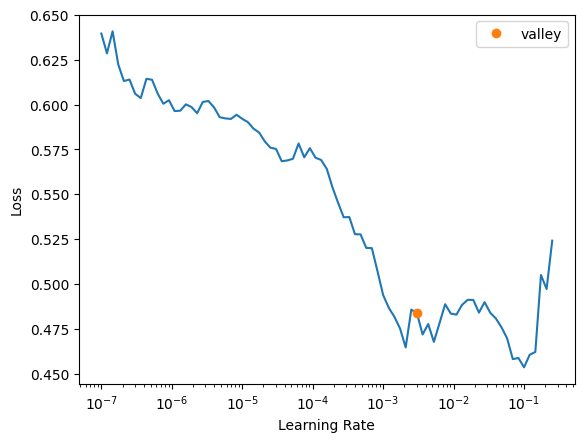

In [22]:
learn.lr_find()

Train the classification head for one epoch

In [23]:
# Train the classification head for one epoch
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,balanced_accuracy_score,average_precision_score,precision_score,recall_score,roc_auc_score,time
0,0.239978,0.215141,0.900407,0.983624,0.942373,0.905537,0.969404,08:51


Unfreeze all model parameters and fine-tune for a further 3 epochs:

In [24]:
model = unfreeze_all(model)
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,balanced_accuracy_score,average_precision_score,precision_score,recall_score,roc_auc_score,time
0,0.198665,0.214524,0.899004,0.983740,0.930435,0.929425,0.969732,11:12
1,0.196837,0.211269,0.906095,0.985394,0.956725,0.888165,0.972510,10:29
2,0.175385,0.197694,0.903181,0.986359,0.941769,0.913138,0.974276,09:52
3,0.146428,0.197213,0.906615,0.986509,0.939427,0.926167,0.974673,12:45
4,0.172642,0.197471,0.902520,0.986558,0.943567,0.907709,0.974673,10:57


Save the model weights for further evaluation and inference:

In [25]:
os.makedirs("./models", exist_ok=True)
torch.save(learn.model.state_dict(), "./models/classification_model_exp04.pth")

Generate validation predictions:

In [27]:
probs, targs = learn.get_preds()
preds = (probs >= 0.5).int()

Final validation metrics:

In [53]:
metric_names = learn.recorder.metric_names[3:-1]
metric_values = learn.recorder.values[0][1:]
print("Final validation metrics:")
for name, value in zip(metric_names, metric_values):
    print(f"{name :<30} {value:.4f}")

Final validation metrics:
balanced_accuracy_score        0.9025
average_precision_score        0.9866
precision_score                0.9436
recall_score                   0.9077
roc_auc_score                  0.9747


Overall, the model is highly accurate. However, looking at the errors may highlight common failure modes that could then be addressed in future iterations of the model. After looking at several errors, some patterns do emerge. One observation is that pools that missed by the model are often near the edge of the photograph. 

In [67]:
errors = (preds.flatten() != targs).nonzero(as_tuple=True)[0].numpy()
error_fps = np.array(valid_fps)[errors]
error_labels = np.array(valid_labels)[errors]
error_preds = preds.flatten().numpy()[errors]
error_probs = probs.flatten().numpy()[errors]
print(f"There are {len(errors)} validation errors out of {len(valid_fps)} ({len(errors)/len(valid_fps)*100:.2f}%).")

There are 118 validation errors out of 1408 (8.38%).


Path: /notebooks/ds_code_challenge_data/images/swimming-pool/yes/W34D_5_30.tif, Label: 1
P(has pool)=0.0935


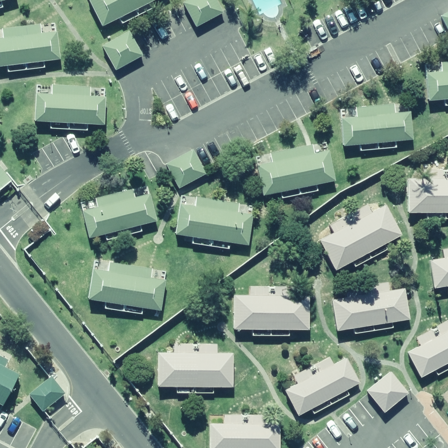

Path: /notebooks/ds_code_challenge_data/images/swimming-pool/no/W25C_7_11.tif, Label: 0
P(has pool)=0.7566


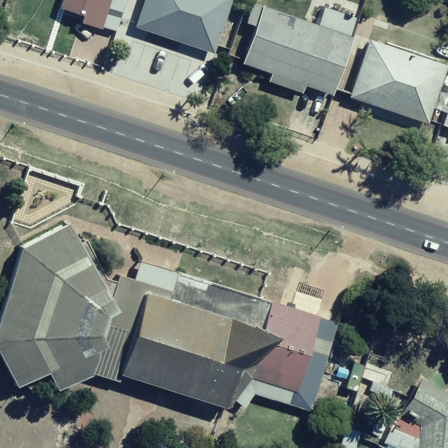

Path: /notebooks/ds_code_challenge_data/images/swimming-pool/yes/W17A_19_87.tif, Label: 1
P(has pool)=0.2898


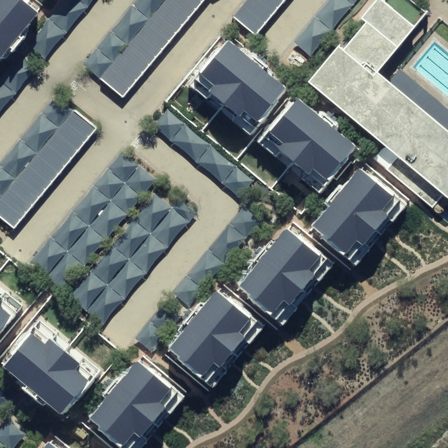

Path: /notebooks/ds_code_challenge_data/images/swimming-pool/no/W17D_11_34.tif, Label: 0
P(has pool)=0.8305


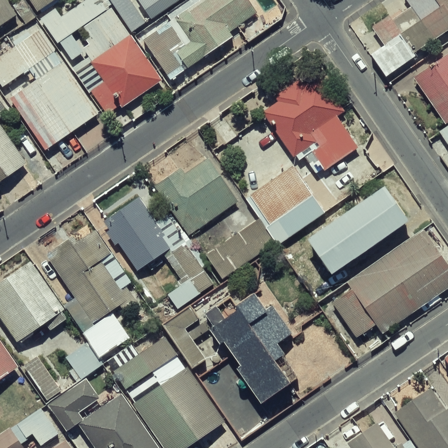

In [71]:
sz = (448, 448)
for _ in range(4):
    i = random.randint(0, len(error_fps)-1)
    print(f"Path: {error_fps[i]}, Label: {error_labels[i]}")
    print(f"P(has pool)={error_probs[i]:.4f}")
    display(Image.open(error_fps[i]).resize(sz))